In [17]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

from sklearn.model_selection import train_test_split


# import from scipy solve_ivp
from scipy.integrate import solve_ivp
import torch
%matplotlib widget

from ray import train, tune
from ray.train import Checkpoint, session, report
from ray.tune.schedulers import ASHAScheduler

import os
import tempfile

In [18]:
path = os.getcwd()
results_dir = os.path.join(path, "../tune")
os.makedirs(results_dir, exist_ok=True)

# Tuning of the PINN for the Damped Harmonic Oscillator ODE

In this notebook we tune the hyperparamenters of the PINN.

## Load data

In [19]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/DHOscillator_data.npy')
data_X = data[:,0]
data_Y = data[:,1:]

In [20]:
def data_loader(X, Y, batch_size, grid_num):
    """
    Function to load data and divide it in batches, specific for
    PINN with grid_num, tunable number of point where enforce the ODE
    input: X, Y, batch_size, grid_num
    output: train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    """

    # divide in train, validation and test
    train_frac = 0.7
    val_frac = 0.15
    test_frac = 0.15

    train_val_X = X[:int((train_frac+val_frac)*len(X))]
    train_val_Y = Y[:int((train_frac+val_frac)*len(X)), :]
    train_X, val_X, train_Y, val_Y = train_test_split(
        train_val_X, 
        train_val_Y, 
        test_size=val_frac/(train_frac+val_frac), 
        random_state=42
        )

    test_X = X[int((train_frac+val_frac)*len(X)):]
    test_Y = Y[int((train_frac+val_frac)*len(X)):, :]

    # dummy PINN dataset for train
    train_X = np.linspace(0, 30, grid_num)
    train_Y = np.zeros((grid_num, 2))

    # convert to torch tensor
    train_X = torch.tensor(train_X, dtype=torch.float32).view(-1, 1)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    val_X = torch.tensor(val_X, dtype=torch.float32).view(-1, 1)
    val_Y = torch.tensor(val_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32).view(-1, 1)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    # divide in batches train
    train_X_batches = torch.split(train_X, batch_size)
    train_Y_batches = torch.split(train_Y, batch_size)

    
    return train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y

## Define hyper model

In [21]:
#  define the model
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 2))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

## Define the Objective

In [22]:
def objective(config):
    net = FFNN(config["n_layers"], config["n_neurons"])

    device = "cpu"

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        factor=config["factor"], 
        patience=config["patience"]
    )

    train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(data_X, data_Y, config["batch_size"], config["grid_num"])

    for epoch in range(50000):
        for i, (X, Y) in enumerate(zip(train_X_batches, train_Y_batches)):
            optimizer.zero_grad()
            X.requires_grad = True
            Y_pred = net(X)

            # get the derivatives
            dx_dt = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
            dv_dt = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]

            # loss_ode and loss_ic 
            loss_ode = torch.mean((dx_dt[:,0] - Y_pred[:,1])**2 + (dv_dt[:,0] + 0.1*Y_pred[:,1] + Y_pred[:,0])**2)
            loss_ic = ((Y_pred[0,0] - 1)**2 + (Y_pred[0,1] - 0)**2)

            loss = 10*loss_ode + loss_ic
        
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
                
        val_loss = criterion(net(val_X), val_Y).item()

        report(metrics={"loss": val_loss})

        if epoch % 100 == 0:
            torch.save(net.state_dict(), "./model.pth")

## Tuning

In [23]:
# configuration space and sampling method
config = {
    "n_layers": tune.randint(3, 4),
    "n_neurons": tune.randint(20, 21),
    "lr" : tune.loguniform(0.01, 0.01),
    "factor": tune.uniform(0.9, 0.9),
    "patience": tune.randint(200, 201),
    "batch_size": tune.randint(595, 596),
    "grid_num": tune.randint(595, 596)
}



# schedueler ASHA
scheduler = ASHAScheduler(
    metric="loss", 
    mode="min", 
    max_t=50000, 
    grace_period=50000, 
    reduction_factor=2
    )


tuner = tune.Tuner(
    objective,
    param_space=config,
    tune_config=tune.TuneConfig(
        num_samples=8,
        scheduler=scheduler,
    ),
    run_config=train.RunConfig(
        name="DHO_PINN_tuning",
        storage_path=results_dir
    )
)

In [24]:
results = tuner.fit()

2024-03-11 19:15:58,165	INFO tune.py:1042 -- Total run time: 1293.05 seconds (1291.41 seconds for the tuning loop).


In [25]:
df = results.get_dataframe()
df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0  0.000002  1710180942                None  True               50000   
1  0.000004  1710180949                None  True               50000   
2  0.000011  1710180950                None  True               50000   
3  0.000070  1710180948                None  True               50000   
4  0.000012  1710180956                None  True               50000   
5  0.000342  1710180955                None  True               50000   
6  0.003339  1710180953                None  True               50000   
7  0.000009  1710180954                None  True               50000   

      trial_id                 date  time_this_iter_s  time_total_s    pid  \
0  65ed5_00000  2024-03-11_19-15-42          0.006503    387.813071  30020   
1  65ed5_00001  2024-03-11_19-15-49          0.005955    387.536820  30021   
2  65ed5_00002  2024-03-11_19-15-50          0.005788    396.236399  30022   
3  65ed5_00003  2024-03-11_19-15-48          0.005741    392.515786  30023   
4  65ed5_00004  2024-03-11_19-15-56          0.003515    396.764433  30024   
5  65ed5_00005  2024-03-11_19-15-55          0.004040    393.595834  30026   
6  65ed5_00006  2024-03-11_19-15-53          0.005997    400.481570  30025   
7  65ed5_00007  2024-03-11_19-15-54          0.006591    399.371196  30027   

   ... time_since_restore iterations_since_restore  config/n_layers  \
0  ...         387.813071                    50000                3   
1  ...         387.536820                    50000                3   
2  ...         396.236399                    50000                3   
3  ...         392.515786                    50000                3   
4  ...         396.764433                    50000                3   
5  ...         393.595834                    50000                3   
6  ...         400.481570                    50000                3   
7  ...         399.371196                    50000                3   

   config/n_neurons  config/lr  config/factor  config/patience  \
0                20       0.01            0.9              200   
1                20       0.01            0.9              200   
2                20       0.01            0.9              200   
3                20       0.01            0.9              200   
4                20       0.01            0.9              200   
5                20       0.01            0.9              200   
6                20       0.01            0.9              200   
7                20       0.01            0.9              200   

   config/batch_size  config/grid_num       logdir  
0                595              595  65ed5_00000  
1                595              595  65ed5_00001  
2                595              595  65ed5_00002  
3                595              595  65ed5_00003  
4                595              595  65ed5_00004  
5                595              595  65ed5_00005  
6                595              595  65ed5_00006  
7                595              595  65ed5_00007  

[8 rows x 22 columns]

In [26]:
def get_alive_model(df, max_epoch):
    """
    Function to get the number of alive models at each epoch
    input: df, max_epoch
    output: alive_model
    """
    # get traininig_iteration vector
    training_iteration = df["training_iteration"]
    training_iteration = training_iteration.to_numpy()
    # alive_model = number of entries of training_iteration > epoch
    # epoch = (0, max_epoch)
    alive_model = np.zeros(max_epoch)
    for i in range(max_epoch):
        alive_model[i] = np.sum(training_iteration > i)
    return alive_model

alive_model = get_alive_model(df, 10000)

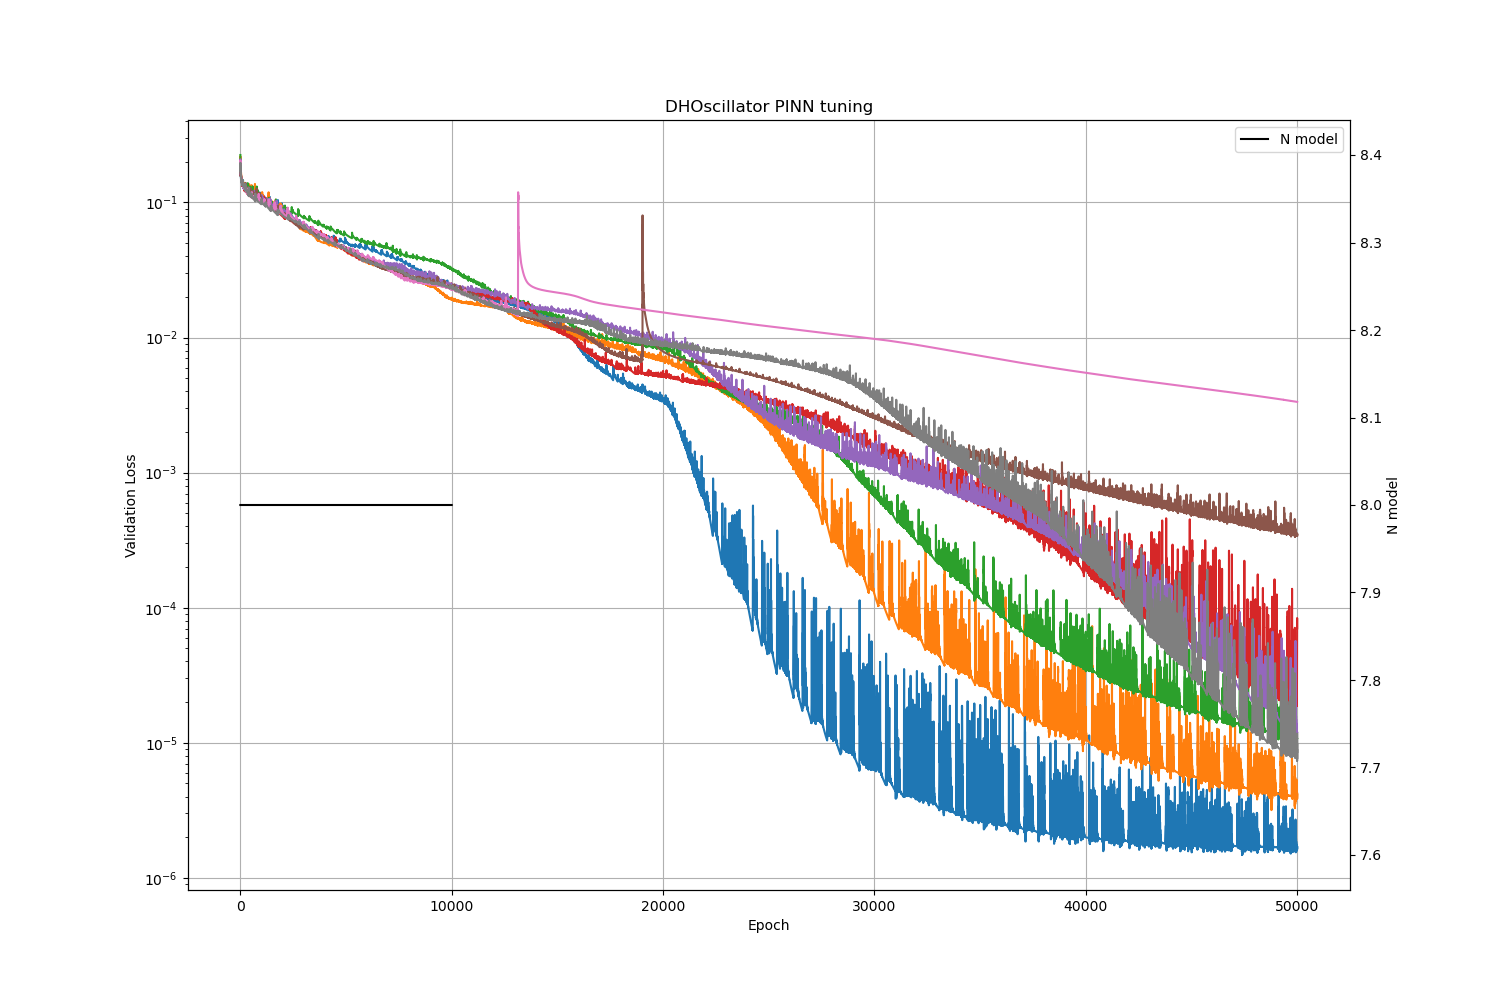

In [27]:
# show results
dfs = {result.path: result.metrics_dataframe for result in results}

# twinx plot alive_model and validation loss
fig, ax1 = plt.subplots(figsize=(15, 10))
# plot the validation loss
for path, df in dfs.items():
    ax1.plot(df["training_iteration"], df["loss"], label=path)
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.grid()

# plot the alive model
ax2 = ax1.twinx()
ax2.plot(alive_model, label="N model", color="black")
ax2.set_ylabel("N model")
ax2.legend()
ax2.grid()


plt.title("DHOscillator PINN tuning")
plt.grid()

# save the plot
plt.savefig("../plot/DHOscillator_PINN_tuning.png")


In [28]:
# get best model
best_result = results.get_best_result("loss", mode="min")
logdir = best_result.path
state_dict = torch.load(os.path.join(logdir, "model.pth"))
best_model = FFNN(best_result.config["n_layers"], best_result.config["n_neurons"])

best_model.load_state_dict(state_dict)

# save best model
torch.save(best_model, "../models/DHO_FFNN_tuned.pt")

In [29]:
# print validation and test loss
train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(
    data_X, 
    data_Y, 
    best_result.config["batch_size"],
    best_result.config["grid_num"]
    )


val_loss = torch.nn.MSELoss()(best_model(val_X), val_Y).item()
test_loss = torch.nn.MSELoss()(best_model(test_X), test_Y).item()

print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")


Validation Loss: 1.6956945501078735e-06
Test Loss: 2.6650916424841853e-06


## Restore results

In [30]:
# restore results
experiment_path = os.path.join(results_dir, "DHO_PINN_tuning")
experiment_path

'/home/luigi/Documents/PHYSICS/ML/Project1/src/../tune/DHO_PINN_tuning'

In [31]:
restored_tuner = tune.Tuner.restore(experiment_path, objective)
restored_results = restored_tuner.get_results()

In [32]:
restored_df = restored_results.get_dataframe()
restored_df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0  0.003339  1710180953                None  True               50000   
1  0.000342  1710180955                None  True               50000   
2  0.000070  1710180948                None  True               50000   
3  0.000002  1710180942                None  True               50000   
4  0.000004  1710180949                None  True               50000   
5  0.000009  1710180954                None  True               50000   
6  0.000011  1710180950                None  True               50000   
7  0.000012  1710180956                None  True               50000   

      trial_id                 date  time_this_iter_s  time_total_s    pid  \
0  65ed5_00006  2024-03-11_19-15-53          0.005997    400.481570  30025   
1  65ed5_00005  2024-03-11_19-15-55          0.004040    393.595834  30026   
2  65ed5_00003  2024-03-11_19-15-48          0.005741    392.515786  30023   
3  65ed5_00000  2024-03-11_19-15-42          0.006503    387.813071  30020   
4  65ed5_00001  2024-03-11_19-15-49          0.005955    387.536820  30021   
5  65ed5_00007  2024-03-11_19-15-54          0.006591    399.371196  30027   
6  65ed5_00002  2024-03-11_19-15-50          0.005788    396.236399  30022   
7  65ed5_00004  2024-03-11_19-15-56          0.003515    396.764433  30024   

   ... time_since_restore iterations_since_restore  config/n_layers  \
0  ...         400.481570                    50000                3   
1  ...         393.595834                    50000                3   
2  ...         392.515786                    50000                3   
3  ...         387.813071                    50000                3   
4  ...         387.536820                    50000                3   
5  ...         399.371196                    50000                3   
6  ...         396.236399                    50000                3   
7  ...         396.764433                    50000                3   

   config/n_neurons  config/lr  config/factor  config/patience  \
0                20       0.01            0.9              200   
1                20       0.01            0.9              200   
2                20       0.01            0.9              200   
3                20       0.01            0.9              200   
4                20       0.01            0.9              200   
5                20       0.01            0.9              200   
6                20       0.01            0.9              200   
7                20       0.01            0.9              200   

   config/batch_size  config/grid_num       logdir  
0                595              595  65ed5_00006  
1                595              595  65ed5_00005  
2                595              595  65ed5_00003  
3                595              595  65ed5_00000  
4                595              595  65ed5_00001  
5                595              595  65ed5_00007  
6                595              595  65ed5_00002  
7                595              595  65ed5_00004  

[8 rows x 22 columns]